Deep Learning Models -- A collection of various deep learning architectures, models, and tips for TensorFlow and PyTorch in Jupyter Notebooks.
- Author: Sebastian Raschka
- GitHub Repository: https://github.com/rasbt/deeplearning-models

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Author: Sebastian Raschka

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 8.30.0

torch: 2.6.0+cu126



# DenseNet-121 CIFAR-10 Image Classifier

### Network Architecture

The network in this notebook is an implementation of the DenseNet-121 [1] architecture on the MNIST digits dataset (http://yann.lecun.com/exdb/mnist/) to train a handwritten digit classifier.  
本笔记本中的网络是基于MNIST数字数据集（http://yann.lecun.com/exdb/mnist/）实现的DenseNet-121 [1]架构，用于训练手写数字分类器。

The following figure illustrates the main concept of DenseNet: within each "dense" block, each layer is connected with each previous layer -- the feature maps are concatenated.  
下图展示了DenseNet的主要概念：在每个“密集”块中，每一层与之前的每一层相连接——特征图被连接在一起。

![](../images/densenet/densenet-fig-2.jpg)  

Note that this is somewhat related yet very different to ResNets. ResNets have skip connections approx. between every other layer (but don't connect all layers with each other).  
请注意，这与ResNets有些关系，但也有很大不同。ResNets大约在每隔一层之间有跳跃连接（但并不连接所有层）。

Also, ResNets skip connections work via addition  
此外，ResNets的跳跃连接通过加法实现

$$\mathbf{x}_{\ell}=H_{\ell}\left(\mathbf{X}_{\ell-1}\right)+\mathbf{X}_{\ell-1}$$,  

whereas $H_{\ell}(\cdot)$ can be a composite function of operations such as Batch Normalization (BN), rectified linear units (ReLU), Pooling, or Convolution (Conv).  
而$H_{\ell}(\cdot)$可以是由批量归一化（BN）、修正线性单元（ReLU）、池化或卷积（Conv）等操作组成的复合函数。

In DenseNets, all the previous feature maps $\mathbf{X}_{0}, \dots, \mathbf{X}_{\ell}-1$ of a feature map $\mathbf{X}_{\ell}$ are concatenated:  
在DenseNets中，所有之前的特征图$\mathbf{X}_{0}, \dots, \mathbf{X}_{\ell}-1$与特征图$\mathbf{X}_{\ell}$连接在一起：

$$\mathbf{x}_{\ell}=H_{\ell}\left(\left[\mathbf{x}_{0}, \mathbf{x}_{1}, \ldots, \mathbf{x}_{\ell-1}\right]\right).$$  

Furthermore, in this particular notebook, we are considering the DenseNet-121, which is depicted below:  
此外，在本笔记本中，我们考虑使用DenseNet-121，如下图所示：

![](../images/densenet/densenet-tab-1-dnet121.jpg)  

**References**  
**参考文献**

- [1] Huang, G., Liu, Z., Van Der Maaten, L., & Weinberger, K. Q. (2017). Densely connected convolutional networks. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 4700-4708), http://openaccess.thecvf.com/content_cvpr_2017/html/Huang_Densely_Connected_Convolutional_CVPR_2017_paper.html  
- [1] Huang, G., Liu, Z., Van Der Maaten, L., & Weinberger, K. Q. (2017). 《密集连接卷积网络》. 载于IEEE计算机视觉与模式识别会议论文集（第4700-4708页），http://openaccess.thecvf.com/content_cvpr_2017/html/Huang_Densely_Connected_Convolutional_CVPR_2017_paper.html  

- [2] http://yann.lecun.com/exdb/mnist/  

## Imports

In [2]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

## Model Settings

In [4]:
##########################
### 设置
##########################

# 超参数
RANDOM_SEED = 1
LEARNING_RATE = 0.001
BATCH_SIZE = 128
NUM_EPOCHS = 20

# 网络结构
NUM_CLASSES = 10

# 其他
DEVICE = "cuda:0"
GRAYSCALE = False

### CIFAR-10 Dataset

In [5]:
train_indices = torch.arange(0, 48000)
valid_indices = torch.arange(48000, 50000)


train_and_valid = datasets.CIFAR10(root='data', 
                                   train=True, 
                                   transform=transforms.ToTensor(),
                                   download=True)

train_dataset = Subset(train_and_valid, train_indices)
valid_dataset = Subset(train_and_valid, valid_indices)
test_dataset = datasets.CIFAR10(root='data', 
                                train=False, 
                                transform=transforms.ToTensor(),
                                download=False)


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE,
                          num_workers=4,
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE,
                          num_workers=4,
                          shuffle=False)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE,
                         num_workers=4,
                         shuffle=False)

In [6]:
device = torch.device(DEVICE)
torch.manual_seed(0)

for epoch in range(2):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(device)
        y = y.to(device)
        break

Epoch: 1 | Batch index: 0 | Batch size: 128
Epoch: 2 | Batch index: 0 | Batch size: 128


In [7]:
# 检查数据洗牌是否正常工作
# 即标签的索引应该是随机顺序的。
# 此外，第二个epoch中的标签顺序应该与第一个不同。

for images, labels in train_loader:  
    pass
print(labels[:10])  # 输出第一次训练时前10个标签

for images, labels in train_loader:  
    pass
print(labels[:10])  # 输出第二次训练时前10个标签

tensor([8, 2, 9, 9, 9, 2, 5, 3, 8, 0])
tensor([6, 0, 1, 7, 6, 2, 6, 5, 5, 1])


In [8]:
# 检查验证集和测试集是否具有多样性
# 即，它们应该包含所有类别

for images, labels in valid_loader:  
    pass
print(labels[:10])  # 输出验证集中的前10个标签

for images, labels in test_loader:  
    pass
print(labels[:10])  # 输出测试集中的前10个标签

tensor([5, 0, 3, 6, 8, 7, 9, 5, 6, 6])
tensor([7, 5, 8, 0, 8, 2, 7, 0, 3, 5])


In [9]:
##########################
### 模型
##########################

# 以下代码实现了DenseNet-121架构
# 该代码是基于来自https://github.com/pytorch/vision/blob/master/torchvision/models/densenet.py的代码

import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from collections import OrderedDict


def _bn_function_factory(norm, relu, conv):
    def bn_function(*inputs):
        concated_features = torch.cat(inputs, 1)  # 拼接输入特征
        bottleneck_output = conv(relu(norm(concated_features)))  # 通过卷积层和激活函数处理拼接的特征
        return bottleneck_output

    return bn_function


class _DenseLayer(nn.Sequential):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate, memory_efficient=False):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features)),  # 第一层批归一化
        self.add_module('relu1', nn.ReLU(inplace=True))  # 第一层ReLU激活函数
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                                           growth_rate, kernel_size=1, stride=1,
                                           bias=False))  # 第一层卷积
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate))  # 第二层批归一化
        self.add_module('relu2', nn.ReLU(inplace=True))  # 第二层ReLU激活函数
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1,
                                           bias=False))  # 第二层卷积
        self.drop_rate = drop_rate  # Dropout概率
        self.memory_efficient = memory_efficient  # 是否使用内存高效的方式

    def forward(self, *prev_features):
        bn_function = _bn_function_factory(self.norm1, self.relu1, self.conv1)  # 获取批归一化和卷积函数
        if self.memory_efficient and any(prev_feature.requires_grad for prev_feature in prev_features):
            bottleneck_output = cp.checkpoint(bn_function, *prev_features)  # 如果需要梯度，则使用checkpoint
        else:
            bottleneck_output = bn_function(*prev_features)  # 否则直接通过卷积
        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))  # 通过第二层卷积得到新的特征
        if self.drop_rate > 0:  # 如果dropout率大于0，则应用dropout
            new_features = F.dropout(new_features, p=self.drop_rate,
                                     training=self.training)
        return new_features


class _DenseBlock(nn.Module):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate, memory_efficient=False):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.add_module('denselayer%d' % (i + 1), layer)  # 添加每一层的DenseLayer

    def forward(self, init_features):
        features = [init_features]  # 初始化特征
        for name, layer in self.named_children():  # 按照顺序通过每一层
            new_features = layer(*features)
            features.append(new_features)
        return torch.cat(features, 1)  # 将所有特征拼接在一起


class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))  # 批归一化层
        self.add_module('relu', nn.ReLU(inplace=True))  # ReLU激活层
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))  # 卷积层
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))  # 平均池化层


class DenseNet121(nn.Module):
    r"""Densenet-BC模型类，基于
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_

    参数:
        growth_rate (int) - 每层添加的过滤器数量（论文中的`k`）
        block_config (list of 4 ints) - 每个池化块中的层数
        num_init_featuremaps (int) - 第一个卷积层的过滤器数量
        bn_size (int) - 瓶颈层的大小倍数（即bn_size * k）
        drop_rate (float) - 每个dense层后的dropout率
        num_classes (int) - 分类类别数
        memory_efficient (bool) - 如果为True，使用checkpoint，内存使用更高效但更慢。默认值为*False*。
    """

    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_featuremaps=64, bn_size=4, drop_rate=0, num_classes=1000, memory_efficient=False,
                 grayscale=False):

        super(DenseNet121, self).__init__()

        # 第一个卷积层
        if grayscale:
            in_channels=1  # 如果是灰度图像，输入通道数为1
        else:
            in_channels=3  # 如果是彩色图像，输入通道数为3
        
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(in_channels=in_channels, out_channels=num_init_featuremaps,
                                kernel_size=7, stride=2,
                                padding=3, bias=False)),  # 第一个卷积层
            ('norm0', nn.BatchNorm2d(num_features=num_init_featuremaps)),  # 批归一化
            ('relu0', nn.ReLU(inplace=True)),  # ReLU激活函数
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),  # 最大池化层
        ]))

        # 每个denseblock
        num_features = num_init_featuremaps
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient
            )
            self.features.add_module('denseblock%d' % (i + 1), block)  # 添加每个denseblock
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)  # 添加transition层
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # 最后的批归一化层
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # 全连接层
        self.classifier = nn.Linear(num_features, num_classes)

        # 使用torch官方初始化方法
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)  # 初始化卷积层权重
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)  # 初始化批归一化层权重
                nn.init.constant_(m.bias, 0)  # 初始化批归一化层偏置
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)  # 初始化全连接层偏置

    def forward(self, x):
        features = self.features(x)  # 获取特征
        out = F.relu(features, inplace=True)  # ReLU激活
        out = F.adaptive_avg_pool2d(out, (1, 1))  # 自适应平均池化
        out = torch.flatten(out, 1)  # 展平
        logits = self.classifier(out)  # 通过全连接层
        probas = F.softmax(logits, dim=1)  # 使用Softmax函数输出分类概率
        return logits, probas  # 返回logits和分类概率

In [10]:
torch.manual_seed(RANDOM_SEED)

model = DenseNet121(num_classes=NUM_CLASSES, grayscale=GRAYSCALE)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

## Training

In [11]:
def compute_acc(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    model.eval()
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        assert predicted_labels.size() == targets.size()
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [12]:
start_time = time.time()  # 记录开始时间

cost_list = []  # 存储每个batch的损失值
train_acc_list, valid_acc_list = [], []  # 存储训练集和验证集的准确率


for epoch in range(NUM_EPOCHS):  # 遍历每个训练轮次
    
    model.train()  # 设置模型为训练模式
    for batch_idx, (features, targets) in enumerate(train_loader):  # 遍历训练数据集
        
        features = features.to(DEVICE)  # 将输入数据移动到指定设备（GPU/CPU）
        targets = targets.to(DEVICE)  # 将标签数据移动到指定设备
            
        ### 前向传播和反向传播
        logits, probas = model(features)  # 获取模型输出
        cost = F.cross_entropy(logits, targets)  # 计算交叉熵损失
        optimizer.zero_grad()  # 清空梯度
        
        cost.backward()  # 反向传播计算梯度
        
        ### 更新模型参数
        optimizer.step()  # 更新模型参数
        
        #################################################
        ### 仅用于日志记录，下面的代码用于输出训练信息
        ################################################
        cost_list.append(cost.item())  # 记录损失值
        if not batch_idx % 150:  # 每150个batch打印一次训练进度
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost:.4f}')  # 输出当前轮次、batch和损失值

        

    model.eval()  # 设置模型为评估模式
    with torch.set_grad_enabled(False):  # 在推理过程中不计算梯度，以节省内存
        
        train_acc = compute_acc(model, train_loader, device=DEVICE)  # 计算训练集准确率
        valid_acc = compute_acc(model, valid_loader, device=DEVICE)  # 计算验证集准确率
        
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d}\n'
              f'Train ACC: {train_acc:.2f} | Validation ACC: {valid_acc:.2f}')  # 输出训练集和验证集准确率
        
        train_acc_list.append(train_acc)  # 记录训练集准确率
        valid_acc_list.append(valid_acc)  # 记录验证集准确率
        
    elapsed = (time.time() - start_time) / 60  # 计算当前已用时间
    print(f'Time elapsed: {elapsed:.2f} min')  # 输出当前已用时间
  
elapsed = (time.time() - start_time) / 60  # 计算总训练时间
print(f'Total Training Time: {elapsed:.2f} min')  # 输出总训练时间

Epoch: 001/020 | Batch 000/375 | Cost: 2.3518
Epoch: 001/020 | Batch 150/375 | Cost: 1.5126
Epoch: 001/020 | Batch 300/375 | Cost: 1.2390
Epoch: 001/020
Train ACC: 56.71 | Validation ACC: 55.35
Time elapsed: 0.31 min
Epoch: 002/020 | Batch 000/375 | Cost: 1.0319
Epoch: 002/020 | Batch 150/375 | Cost: 0.9400
Epoch: 002/020 | Batch 300/375 | Cost: 0.8634
Epoch: 002/020
Train ACC: 59.76 | Validation ACC: 56.85
Time elapsed: 0.64 min
Epoch: 003/020 | Batch 000/375 | Cost: 0.8543
Epoch: 003/020 | Batch 150/375 | Cost: 0.7138
Epoch: 003/020 | Batch 300/375 | Cost: 0.7828
Epoch: 003/020
Train ACC: 73.67 | Validation ACC: 69.85
Time elapsed: 0.95 min
Epoch: 004/020 | Batch 000/375 | Cost: 0.5887
Epoch: 004/020 | Batch 150/375 | Cost: 0.6672
Epoch: 004/020 | Batch 300/375 | Cost: 0.6449
Epoch: 004/020
Train ACC: 72.84 | Validation ACC: 67.20
Time elapsed: 1.28 min
Epoch: 005/020 | Batch 000/375 | Cost: 0.6213
Epoch: 005/020 | Batch 150/375 | Cost: 0.4943
Epoch: 005/020 | Batch 300/375 | Cost: 0

## Evaluation

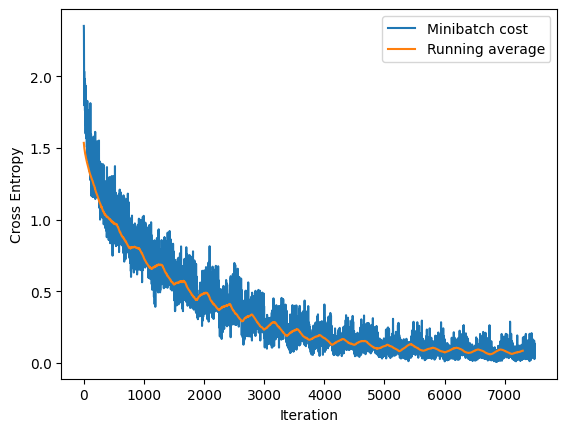

In [13]:
plt.plot(cost_list, label='Minibatch cost')
plt.plot(np.convolve(cost_list, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()


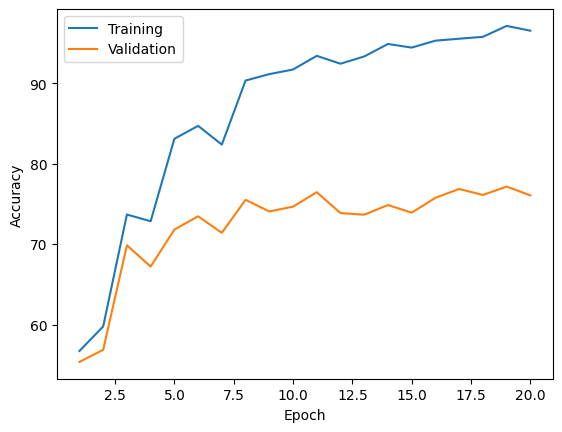

In [14]:
train_acc_list_cpu = [x.cpu().numpy() for x in train_acc_list]   # 将张量移到 CPU 并转换为 numpy 数组
valid_acc_list_cpu = [x.cpu().numpy() for x in valid_acc_list]
plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list_cpu, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list_cpu, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [15]:
with torch.set_grad_enabled(False):
    test_acc = compute_acc(model=model,
                           data_loader=test_loader,
                           device=DEVICE)
    
    valid_acc = compute_acc(model=model,
                            data_loader=valid_loader,
                            device=DEVICE)
    

print(f'Validation ACC: {valid_acc:.2f}%')
print(f'Test ACC: {test_acc:.2f}%')

Validation ACC: 76.05%
Test ACC: 75.08%


In [16]:
%watermark -iv

matplotlib : 3.10.1
torchvision: 0.21.0+cu126
numpy      : 2.1.2
re         : 2.2.1
PIL        : 11.0.0
pandas     : 2.2.3
torch      : 2.6.0+cu126

